In [1]:
%load_ext autoreload
%autoreload 2
import os
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/braindecode/')

# Cropped Decoding

Now we will use cropped decoding. Cropped decoding means the ConvNet is trained on time windows/time crops within the trials. We will explain this visually by comparing trialwise to cropped decoding.



Trialwise Decoding | Cropped Decoding
- | - 
![Trialwise Decoding](./trialwise_explanation.png "Trialwise Decoding") | ![Cropped Decoding](./cropped_explanation.png "Cropped Decoding")

On the left, you see trialwise decoding:

1. A complete trial is pushed through the network
2. The network produces a prediction
3. The prediction is compared to the target (label) for that trial to compute the loss


On the right, you see cropped decoding:

1. Instead of a complete trial, windows within the trial, here called *crops*, are pushed through the network
2. For computational efficiency, multiple neighbouring crops are pushed through the network simultaneously (these neighbouring crops are called a *supercrop*)
3. Therefore, the network produces multiple predictions (one per crop in the supercrop)
4. The individual crop predictions are averaged before computing the loss function


Notes:

* The network architecture implicitly defines the crop size (it is the receptive field size, i.e., the number of timesteps the network uses to make a single prediction)
* The supercrop size is a user-defined hyperparameter, called `input_time_length` in Braindecode. It mostly affects runtime (larger supercrop sizes should be faster). As a rule of thumb, you can set it to two times the crop size.
* Crop size and supercrop size together define how many predictions the network makes per supercrop:  $\mathrm{\#supercrop}-\mathrm{\#crop}+1=\mathrm{\#predictions}$

For cropped decoding, the above training setup is mathematically identical to sampling crops in your dataset, pushing them through the network and training directly on the individual crops. At the same time, the above training setup is much faster as it avoids redundant computations by using dilated convolutions, see our paper [Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051). However, the two setups are only mathematically identical in case (1) your network does not use any padding and (2) your loss function leads to the same gradients when using the averaged output. The first is true for our shallow and deep ConvNet models and the second is true for the log-softmax outputs and negative log likelihood loss that is typically used for classification in PyTorch.

Most of the code for cropped decoding is identical to the [Trialwise Decoding Tutorial](Trialwise_Decoding.html), differences are explained in the text.

## Enable logging

In [2]:
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('INFO')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

## Load data

In [3]:
import mne
from mne.io import concatenate_raws

# 5,6,7,10,13,14 are codes for executed and imagined hands/feet
subject_id = 22
event_codes = [5,6,9,10,13,14]
#event_codes = [3,4,5,6,7,8,9,10,11,12,13,14]

# This will download the files if you don't have them yet,
# and then return the paths to the files.
physionet_paths = mne.datasets.eegbci.load_data(subject_id, event_codes)

# Load each of the files
parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto', verbose='WARNING')
         for path in physionet_paths]

# Concatenate them
raw = concatenate_raws(parts)

# Find the events in this dataset
events, _ = mne.events_from_annotations(raw)

# Use only EEG channels
eeg_channel_inds = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Extract trials, only using EEG channels
epoched = mne.Epochs(raw, events, dict(hands_or_left=2, feet_or_right=3), tmin=1, tmax=4.1, proj=False, picks=eeg_channel_inds,
                baseline=None, preload=True)

## Convert data to Braindecode format

In [4]:
import numpy as np
# Convert data from volt to millivolt
# Pytorch expects float32 for input and int64 for labels.
X = (epoched.get_data() * 1e6).astype(np.float32)
y = (epoched.events[:,2] - 2).astype(np.int64) #2,3 -> 0,1

In [5]:
from braindecode.datautil.signal_target import SignalAndTarget

train_set = SignalAndTarget(X[:40], y=y[:40])
valid_set = SignalAndTarget(X[40:70], y=y[40:70])


## Create the model

<div class="alert alert-info">

As in the trialwise decoding tutorial, we will use the Braindecode model class directly to perform the training in a few lines of code. If you instead want to use your own training loop, have a look at the [Cropped Manual Training Loop Tutorial](./Cropped_Manual_Training_Loop.html).
</div>

For cropped decoding, we now transform the model into a model that outputs a dense time series of predictions.
For this, we manually set the length of the final convolution layer to some length that makes the receptive field of the ConvNet smaller than the number of samples in a trial (see `final_conv_length=12` in the model definition). 

In [6]:
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from torch import nn
from braindecode.torch_ext.util import set_random_seeds

# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = False
set_random_seeds(seed=20170629, cuda=cuda)
n_classes = 2
in_chans = train_set.X.shape[1]

model = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=None,
                        final_conv_length=12)
if cuda:
    model.cuda()


Now we supply `cropped=True` to our compile function 

In [7]:
from braindecode.torch_ext.optimizers import AdamW
import torch.nn.functional as F
#optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
optimizer = AdamW(model.parameters(), lr=0.0625 * 0.01, weight_decay=0)
model.compile(loss=F.nll_loss, optimizer=optimizer,  iterator_seed=1, cropped=True)

## Run the training

For fitting, we must supply the super crop size. Here, we it to 450 by setting `input_time_length = 450`.

In [8]:
input_time_length = 450
model.fit(train_set.X, train_set.y, epochs=30, batch_size=64, scheduler='cosine',
          input_time_length=input_time_length,
         validation_data=(valid_set.X, valid_set.y),)

2019-05-27 13:48:25,992 INFO : Run until first stop...
2019-05-27 13:48:28,722 INFO : Epoch 0
2019-05-27 13:48:28,736 INFO : train_loss                16.71894
2019-05-27 13:48:28,737 INFO : valid_loss                16.03879
2019-05-27 13:48:28,738 INFO : train_misclass            0.52500
2019-05-27 13:48:28,738 INFO : valid_misclass            0.53333
2019-05-27 13:48:28,739 INFO : runtime                   0.00000
2019-05-27 13:48:28,740 INFO : 
2019-05-27 13:48:32,953 INFO : Time only for training updates: 4.21s
2019-05-27 13:48:35,792 INFO : Epoch 1
2019-05-27 13:48:35,806 INFO : train_loss                5.75666
2019-05-27 13:48:35,807 INFO : valid_loss                5.05206
2019-05-27 13:48:35,808 INFO : train_misclass            0.52500
2019-05-27 13:48:35,809 INFO : valid_misclass            0.53333
2019-05-27 13:48:35,810 INFO : runtime                   6.95663
2019-05-27 13:48:35,810 INFO : 
2019-05-27 13:48:39,861 INFO : Time only for training updates: 4.05s
2019-05-27 13

2019-05-27 13:49:49,042 INFO : valid_misclass            0.16667
2019-05-27 13:49:49,042 INFO : runtime                   3.25675
2019-05-27 13:49:49,043 INFO : 
2019-05-27 13:49:50,972 INFO : Time only for training updates: 1.92s
2019-05-27 13:49:52,316 INFO : Epoch 18
2019-05-27 13:49:52,317 INFO : train_loss                0.09406
2019-05-27 13:49:52,318 INFO : valid_loss                0.40693
2019-05-27 13:49:52,318 INFO : train_misclass            0.00000
2019-05-27 13:49:52,319 INFO : valid_misclass            0.16667
2019-05-27 13:49:52,320 INFO : runtime                   3.27348
2019-05-27 13:49:52,320 INFO : 
2019-05-27 13:49:54,240 INFO : Time only for training updates: 1.91s
2019-05-27 13:49:55,578 INFO : Epoch 19
2019-05-27 13:49:55,579 INFO : train_loss                0.08521
2019-05-27 13:49:55,579 INFO : valid_loss                0.38600
2019-05-27 13:49:55,580 INFO : train_misclass            0.00000
2019-05-27 13:49:55,581 INFO : valid_misclass            0.13333
201

In [9]:
model.epochs_df

train_loss  valid_loss  train_misclass  valid_misclass   runtime
0    16.718943   16.038786           0.525        0.533333  0.000000
1     5.756664    5.052062           0.525        0.533333  6.956634
2     3.647677    3.016214           0.500        0.533333  6.908031
3     2.342561    1.909614           0.500        0.533333  7.240101
4     1.506759    1.290458           0.475        0.500000  7.399405
5     1.019237    0.968446           0.400        0.433333  7.065770
6     0.758563    0.821283           0.350        0.433333  7.214281
7     0.611557    0.758545           0.300        0.433333  5.655106
8     0.518917    0.740452           0.250        0.366667  3.405795
9     0.433832    0.710416           0.200        0.300000  3.383932
10    0.342782    0.652211           0.175        0.266667  3.303478
11    0.270821    0.600610           0.150        0.266667  3.260772
12    0.218609    0.563165           0.025        0.266667  3.459012
13    0.181991    0.535691           0.000        0.233333  3.346393
14    0.154839    0.508405           0.000        0.200000  3.260915
15    0.133887    0.480797           0.000        0.166667  3.267457
16    0.117386    0.454011           0.000        0.133333  3.318306
17    0.104724    0.430165           0.000        0.166667  3.256755
18    0.094064    0.406926           0.000        0.166667  3.273476
19    0.085207    0.386002           0.000        0.133333  3.268065
20    0.077945    0.367422           0.000        0.133333  3.257596
21    0.071709    0.350847           0.000        0.100000  3.971547
22    0.066811    0.337260           0.000        0.100000  4.507347
23    0.062891    0.325995           0.000        0.100000  6.996382
24    0.059993    0.317353           0.000        0.100000  6.871776
25    0.057849    0.310633           0.000        0.100000  6.769685
26    0.056350    0.305617           0.000        0.100000  6.659091
27    0.055315    0.301796           0.000        0.100000  6.849715
28    0.054613    0.298791           0.000        0.100000  6.767460
29    0.054149    0.296389           0.000        0.100000  6.771852
30    0.053844    0.294413           0.000        0.100000  6.877121

Eventually, we arrive at 90% accuracy, so 27 from 30 trials are correctly predicted.

## Evaluation

In [10]:
test_set = SignalAndTarget(X[70:], y=y[70:])

model.evaluate(test_set.X, test_set.y)

{'loss': 0.4238094389438629,
 'misclass': 0.09999999999999998,
 'runtime': 0.00041961669921875}

We can now predict entire trials as before or individual crops.

In [11]:
model.predict_classes(test_set.X)

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1])

In [12]:
model.predict_outs(test_set.X)

array([[-1.2750863e+00, -4.7210640e-01],
       [-6.4165510e-02, -3.2850025e+00],
       [-1.2179451e+00, -9.6833640e-01],
       [-9.6923895e-02, -2.7711761e+00],
       [-1.5608791e-02, -4.4860415e+00],
       [-3.0281614e-03, -6.5692320e+00],
       [-3.3592165e+00, -9.9474899e-02],
       [-5.2215487e-01, -1.3793353e+00],
       [-7.2297215e-02, -3.2223554e+00],
       [-1.8260284e-01, -2.6842451e+00],
       [-1.1441530e+00, -5.1276696e-01],
       [-2.6686563e+00, -2.3944007e-01],
       [-3.9805791e-01, -1.4446534e+00],
       [-8.5448694e-01, -5.9342915e-01],
       [-4.0538985e-01, -1.5777966e+00],
       [-1.4246053e+00, -4.7016972e-01],
       [-1.7791660e+00, -3.6660773e-01],
       [-1.0101254e+00, -6.9896615e-01],
       [-2.7277711e-01, -2.1119595e+00],
       [-1.4588629e+00, -4.5223159e-01]], dtype=float32)

For individual crops, provide `individual_crops=True`. This for example can be useful to plot accuracies over time:

Text(0, 0.5, 'Accuracy [%]')

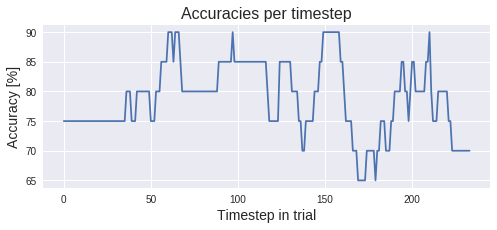

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
%matplotlib inline
matplotlib.style.use('seaborn')
labels_per_trial_per_crop = model.predict_classes(test_set.X, individual_crops=True)
accs_per_crop = [l == y for l,y in zip(labels_per_trial_per_crop, test_set.y)]
accs_per_crop = np.mean(accs_per_crop, axis=0)
plt.figure(figsize=(8,3))
plt.plot(accs_per_crop * 100)
plt.title("Accuracies per timestep", fontsize=16)
plt.xlabel('Timestep in trial', fontsize=14)
plt.ylabel('Accuracy [%]', fontsize=14)

Raw outputs could be used to visualize a prediction probability across a trial. Here we look at the first trial.

Text(0, 0.5, 'Probabilities')

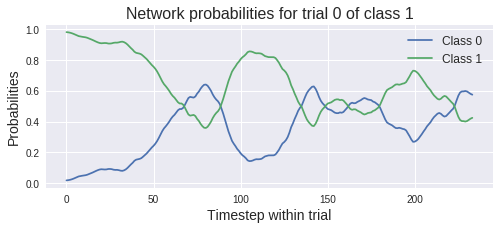

In [14]:
cropped_outs = model.predict_outs(test_set.X, individual_crops=True)
i_trial = 0
# log-softmax outputs need to be exponentiated to get probabilities
cropped_probs = np.exp(cropped_outs[i_trial])
plt.figure(figsize=(8,3))
plt.plot(cropped_probs.T)
plt.title("Network probabilities for trial {:d} of class {:d}".format(
    i_trial, test_set.y[i_trial]), fontsize=16)
plt.legend(("Class 0", "Class 1"), fontsize=12)
plt.xlabel("Timestep within trial", fontsize=14)
plt.ylabel("Probabilities", fontsize=14)

## Dataset references


 This dataset was created and contributed to PhysioNet by the developers of the [BCI2000](http://www.schalklab.org/research/bci2000) instrumentation system, which they used in making these recordings. The system is described in:
 
     Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. (2004) BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE TBME 51(6):1034-1043.

[PhysioBank](https://physionet.org/physiobank/) is a large and growing archive of well-characterized digital recordings of physiologic signals and related data for use by the biomedical research community and further described in:

    Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. (2000) PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220.